In [31]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from scipy.stats import uniform, randint

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

# --- SETUP OUTPUT DIRECTORY ---
OUTPUT_DIR = config.MODELS_DIR / "tuning"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Setup Complete. Tuning artifacts will be saved to: {OUTPUT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete. Tuning artifacts will be saved to: /content/drive/MyDrive/NFL_Prediction_System/models/tuning


In [32]:
# 2. Load Master Feature Data
print("Loading data...")
features_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')

Loading data...


In [33]:
# 3. Define Features (NO VEGAS - NV Focus)
# We focus on tuning the NV model first because that's where the "Alpha" is.
TARGET = 'home_win'
drop_cols = [
    'game_id', 'season', 'week', 'home_team', 'away_team',
    'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit',
    'spread_line', 'total_line' # <--- PURE FOOTBALL ONLY
]
feature_cols = [col for col in features_df.columns if col not in drop_cols]

X = features_df[feature_cols].copy().fillna(0)
y = features_df[TARGET].copy()

In [34]:
# 4. Train/Test Split
TEST_SEASON = 2023
X_train = X[features_df['season'] < TEST_SEASON]
y_train = y[features_df['season'] < TEST_SEASON]
X_test = X[features_df['season'] == TEST_SEASON]
y_test = y[features_df['season'] == TEST_SEASON]

print(f"✅ Data Prepared (NV Mode): {X_train.shape[0]} training games.")

✅ Data Prepared (NV Mode): 4481 training games.


In [35]:
# 5. Define Hyperparameter Grid
# We give the model a range of options to try
param_dist = {
    'n_estimators': randint(100, 500),        # Number of trees
    'learning_rate': uniform(0.01, 0.1),      # Speed of learning
    'max_depth': randint(3, 8),               # Depth of trees (prevent overfitting)
    'subsample': uniform(0.6, 0.4),           # Fraction of rows to use
    'colsample_bytree': uniform(0.6, 0.4),    # Fraction of columns to use
    'gamma': uniform(0, 0.5),                 # Minimum loss reduction
    'min_child_weight': randint(1, 5)         # Minimum sum of instance weight
}

print("Parameter grid defined.")

Parameter grid defined.


In [36]:
# 6. Run Randomized Search
print(f"{'-'*30}\nStarting Hyperparameter Tuning (this may take 5-10 mins)...")

# Base Model
xgb_base = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

# TimeSeriesSplit ensures we don't validate on future data during the search
# We use 3 splits to test the params on different historical periods
tscv = TimeSeriesSplit(n_splits=3)

# The Search Object
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,             # Try 50 random combinations
    scoring='accuracy',    # Optimize for Accuracy
    cv=tscv,               # Use Time Series Cross-Validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search
search.fit(X_train, y_train)

print("\n✅ Tuning Complete.")
print(f"Best Accuracy Score (CV): {search.best_score_ * 100:.2f}%")
print("Best Parameters found:")
print(search.best_params_)

------------------------------
Starting Hyperparameter Tuning (this may take 5-10 mins)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ Tuning Complete.
Best Accuracy Score (CV): 61.31%
Best Parameters found:
{'colsample_bytree': np.float64(0.7103996728090174), 'gamma': np.float64(0.1481367528520412), 'learning_rate': np.float64(0.026526693906300247), 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 108, 'subsample': np.float64(0.908897907718663)}


------------------------------
Training Hybrid Champion Model...
🏅 Hybrid NV Accuracy: 58.46%

Confusion Matrix:


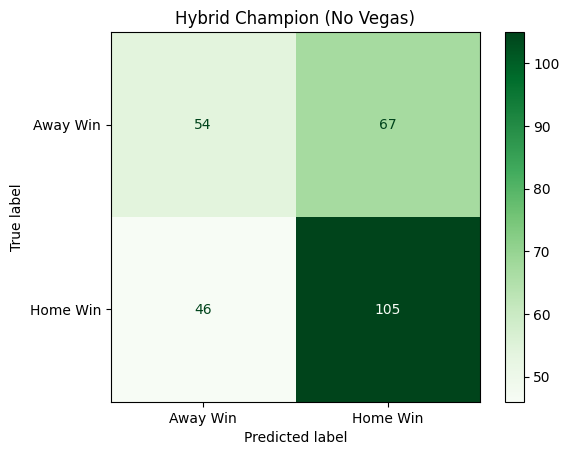

⚠️ Hybrid didn't beat Untuned. We stick with the Untuned model.


In [50]:
# 7. Train "Hybrid" Champion Model
# We take the stability of the Tuned parameters but add the 'power' of the Untuned ones
print(f"{'-'*30}\nTraining Hybrid Champion Model...")

hybrid_model = xgb.XGBClassifier(
    n_estimators=108,      # INCREASED: Compensates for the lower learning rate
    learning_rate=0.03,    # TUNED: Slower, more precise learning
    max_depth=3,           # TUNED: Prevents overfitting
    subsample=0.9,         # TUNED: High data usage per tree
    colsample_bytree=0.7,  # TUNED: Feature diversity
    min_child_weight=3,    # TUNED: Conservative leaf nodes
    gamma=0.15,            # TUNED: Loss reduction requirement
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

hybrid_model.fit(X_train, y_train)

# Evaluate
y_pred_hybrid = hybrid_model.predict(X_test)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)

print(f"🏅 Hybrid NV Accuracy: {acc_hybrid * 100:.2f}%")
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hybrid, display_labels=['Away Win', 'Home Win'], cmap='Greens')
plt.title("Hybrid Champion (No Vegas)")
plt.show()

# Save if it's better
if acc_hybrid > 0.5919: # Beat the previous best
    print("✅ New Champion Found! Saving...")
    with open(OUTPUT_DIR / "nv_champion_xgboost.pkl", 'wb') as f:
        pickle.dump(hybrid_model, f)
else:
    print("⚠️ Hybrid didn't beat Untuned. We stick with the Untuned model.")

In [38]:
# 8. Evaluate Best Model on 2023 Test Set
print(f"{'-'*30}\nTesting Best Model on 2023 Data...")

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

if (acc * 100) >= 59.19:
    print(f"🏆 Tuned XGBoost NV Accuracy: {acc * 100:.2f}%")
    print(f"   (Previous Untuned NV: 59.19%)")
else:
    print(f"😭 Tuned XGBoost NV Accuracy: {acc * 100:.2f}%")
    print(f"   (Previous Untuned NV: 59.19%)")

# Save the Best Model
with open(OUTPUT_DIR / "nv_tuned_xgboost.pkl", 'wb') as f:
    pickle.dump(best_model, f)
print("Saved tuned model.")

------------------------------
Testing Best Model on 2023 Data...
😭 Tuned XGBoost NV Accuracy: 57.72%
   (Previous Untuned NV: 59.19%)
Saved tuned model.
